# start

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np

import copy
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from collections import defaultdict

folder = "test_results"
os.makedirs(folder, exist_ok=True)

# track neff with beta

In [2]:
def mask_pc(module:nn.Module, beta=1.0, method='magnitude') -> torch.Tensor:
    x = module.weight.data
    output_size, input_size = x.shape
    if method == 'mean':
        x = x - x.mean(dim=0, keepdim=True)
    x_norm = torch.abs(x) / torch.sum(torch.abs(x), dim=0, keepdim=True)
    neff = 1/torch.sum((x_norm ** 2), dim=0, keepdim=True).squeeze(0)
    r_neff = torch.floor(beta * neff)
    r_neff = r_neff.clamp(min=1, max=output_size-1)

    _, indices = torch.sort(x_norm, dim=0, descending=True)
    range_tensor = torch.arange(output_size, device=x.device).unsqueeze(0).expand(input_size, -1).T
    sorted_mask = range_tensor < r_neff
    
    mask = torch.zeros_like(x, dtype=torch.bool)
    mask.scatter_(0, indices, sorted_mask)
    return mask, torch.floor(neff)

def model_pc(model, renormalize=False, beta=1.0, method='magnitude'):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            mask, neff = mask_pc(module, beta=beta, method=method)
            mask = mask.to(module.weight.device)
            with torch.no_grad():
                pre = module.weight.abs().sum(dim=0, keepdim=True)
                module.weight *= mask
                if renormalize:
                    post = module.weight.abs().sum(dim=0, keepdim=True)
                    module.weight.mul_(pre / post)
    return model, neff

def mask_pr(module:nn.Module, beta=1.0, method='magnitude') -> torch.Tensor:
    x = module.weight.data
    output_size, input_size = x.shape
    if method == 'mean':
        x = x - x.mean(dim=1, keepdim=True)
    x_norm = torch.abs(x) / torch.sum(torch.abs(x), dim=1, keepdim=True)
    neff = 1/torch.sum((x_norm ** 2), dim=1, keepdim=True).squeeze(0)
    r_neff = torch.floor(beta * neff)
    r_neff = r_neff.clamp(min=1, max=input_size-1)

    _, indices = torch.sort(x_norm, dim=1, descending=True)
    range_tensor = torch.arange(input_size, device=x.device).unsqueeze(0).expand(output_size, -1)
    sorted_mask = range_tensor < r_neff

    mask = torch.zeros_like(x, dtype=torch.bool)
    mask.scatter_(1, indices, sorted_mask)
    return mask, torch.floor(neff)

def model_pr(model, renormalize=False, beta=1.0, method='magnitude'):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            mask, neff = mask_pr(module, beta=beta, method=method)
            mask = mask.to(module.weight.device)
            with torch.no_grad():
                pre = module.weight.abs().sum(dim=1, keepdim=True)
                module.weight *= mask
                if renormalize:
                    post = module.weight.abs().sum(dim=1, keepdim=True)
                    module.weight.mul_(pre / post)
    return model, neff

def mask_block(module:nn.Module, beta=1.0, method='magnitude') -> torch.Tensor:
    x = module.weight.data
    x = x.view(-1)
    if method == 'mean':
        x = x - torch.mean(x)
    x_norm = torch.abs(x) / torch.sum(torch.abs(x))
    neff = 1/torch.sum((x_norm ** 2))
    r_neff = torch.floor(beta * neff)
    r_neff = r_neff.clamp(min=1, max=len(x)-1)

    _, indices = torch.sort(x_norm, descending=True)
    range_tensor = torch.arange(len(x), device=x.device)
    sorted_mask = range_tensor < r_neff

    mask = torch.zeros_like(x, dtype=torch.bool)
    mask.scatter_(0, indices, sorted_mask)
    mask = mask.view_as(module.weight)
    return mask, torch.floor(neff)

def model_block(model, renormalize=False, beta=1.0, method='magnitude'):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            mask, neff = mask_block(module, beta=beta, method=method)
            mask = mask.to(module.weight.device)
            with torch.no_grad():
                pre = module.weight.abs().sum(dim=0, keepdim=True)
                module.weight *= mask
                if renormalize:
                    post = module.weight.abs().sum(dim=0, keepdim=True)
                    module.weight.mul_(pre / post)
    return model, neff

In [3]:
def model_sparsity(model):
    """Calculate the sparsity of the model"""
    total_params = 0
    zero_params = 0
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += torch.sum(param == 0).item()
    
    sparsity = zero_params / total_params
    return sparsity

def per_layer_neff(model):
    """Calculate the effective parameters (Neff) per layer"""
    neff = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            layer_neff = torch.sum(param != 0).item()
            neff[name] = layer_neff
    return neff

In [6]:
# Dataset setup
batch_size = 64
test_batch_size = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model class with optional dropout
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[512, 512, 512], dropout_rate=0.0):
        super(LinearModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        prev_size = input_size
        for size in hidden_size:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
            
        self.output = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        
        for layer in self.layers:
            x = F.relu(layer(x))
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)
        return F.log_softmax(x, dim=1)
    
    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))

# Training function
def train(model, device, train_loader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 200 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}'
                  f'accuracy: {100. * correct / len(train_loader.dataset):.2f}%')

    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Testing function
def test(model, device, test_loader, times=1):
    """Evaluate model on test set"""
    model.eval()
    accuracy_list = []
    loss_list = []
    for _ in range(times):
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        accuracy_list.append(accuracy)
        loss_list.append(test_loss)

    if times == 1:
        print(f'Test set: Average loss: {test_loss:.4f}, '
              f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

        return test_loss, accuracy
    
    else:
        return loss_list, accuracy_list, sum(accuracy_list)/times

Using device: cuda


In [4]:
# Model configurations
model_configs = {
    'Model_1_Underfit': {
        'hidden_size': [64, 32, 16],  # Very shallow, only 1 small hidden layer
        'lr': 1e-4,  # Lower learning rate
        'epochs': 5,  # Fewer epochs
        'dropout': 0.0,
        'description': 'Underfitted: Too simple (1 layer, 32 units)'
    },
    'Model_2_Slight_Underfit': {
        'hidden_size': [256, 128, 64],  # 2 small layers
        'lr': 5e-4,
        'epochs': 8,
        'dropout': 0.0,
        'description': 'Slightly underfitted: Simple architecture'
    },
    'Model_3_Well_Trained': {
        'hidden_size': [512, 256, 128],  # Moderate depth and width
        'lr': 3e-4,
        'epochs': 15,
        'dropout': 0.2,  # Some regularization
        'description': 'Well-trained: Balanced architecture with dropout'
    },
    'Model_4_Well_Trained_Deep': {
        'hidden_size': [1024, 512, 256],  # Deeper but with dropout
        'lr': 3e-4,
        'epochs': 20,
        'dropout': 0.3,  # More dropout for regularization
        'description': 'Well-trained: Deeper with good regularization'
    },
    'Model_5_Overfit': {
        'hidden_size': [2048, 1024, 1024],  # Very deep and wide
        'lr': 1e-3,  # Higher learning rate
        'epochs': 30,  # Many epochs
        'dropout': 0.0,  # No regularization
        'description': 'Overfitted: Very complex without regularization'
    },
    'Model_6_Extra_Overfit': {
        'hidden_size': [4096, 2048, 1024],  # Extremely deep and wide
        'lr': 1e-3,
        'epochs': 50,
        'dropout': 0.0,
        'description': 'Extra Overfitted: Very complex without regularization'
    },
    'Model_7_Extra_Overfit': {
        'hidden_size': [8192, 4096, 2048],  # Extremely deep and wide
        'lr': 1e-3,
        'epochs': 100,
        'dropout': 0.0,
        'description': 'Extra Overfitted: Very complex without regularization'
    }
}

In [7]:
result = {
    'model_name': [],
    'test_accuracy': [],
    'model_sparsity': [],
    'shadow_accuracy': []
}


for model_name, config in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}: {config['description']}")
    print(f"Architecture: Input(784) -> {' -> '.join(map(str, config['hidden_size']))} -> Output(10)")
    print(f"Learning rate: {config['lr']}, Epochs: {config['epochs']}, Dropout: {config['dropout']}")
    print(f"{'='*60}")
    
    # Create model
    model = LinearModel(
        input_size=28*28, 
        output_size=10, 
        hidden_size=config['hidden_size'],
        dropout_rate=config['dropout']
    ).to(device)
    model.load(f'models/MNIST_model/{model_name}.pth')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    test_loss, test_accuracy, origin_test_accuracy = test(model, device, test_loader, times=5)
    
    result['model_name'].append(model_name)
    result['test_accuracy'].append(origin_test_accuracy)
    result['model_sparsity'].append(0.0)
    result['shadow_accuracy'].append(test_accuracy)
    
    for beta in [0.25, 0.5, 2/3, 0.75, 0.8, 1.0, 5/4, 4/3, 3/2, 2.0, 4.0]:
        # magnitude
        pc_model, pc_neff = model_pc(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        pr_model, pr_neff = model_pr(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        pb_model, pb_neff = model_block(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # mean
        mean_pc_model, mean_pc_neff = model_pc(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pr_model, mean_pr_neff = model_pr(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pb_model, mean_pb_neff = model_block(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # summary
        print('\t')
        print('='*40)
        print(f"model name: {model_name}, test accuracy: {origin_test_accuracy:.2f}%, beta: {beta}")
        print(f"per column magnitude pruning test accuracy: {result['test_accuracy'][-6]:.2f}%, sparsity: {result['model_sparsity'][-4]:.4f}")
        print(f"per row magnitude pruning test accuracy: {result['test_accuracy'][-5]:.2f}%, sparsity: {result['model_sparsity'][-3]:.4f}")
        print(f"per block magnitude pruning test accuracy: {result['test_accuracy'][-4]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean column mean pruning test accuracy: {result['test_accuracy'][-3]:.2f}%, sparsity: {result['model_sparsity'][-2]:.4f}")
        print(f"mean row mean pruning test accuracy: {result['test_accuracy'][-2]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean block mean pruning test accuracy: {result['test_accuracy'][-1]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")


Training Model_1_Underfit: Underfitted: Too simple (1 layer, 32 units)
Architecture: Input(784) -> 64 -> 32 -> 16 -> Output(10)
Learning rate: 0.0001, Epochs: 5, Dropout: 0.0
Total parameters: 53,018
	
model name: Model_1_Underfit, test accuracy: 93.61%, beta: 0.25
per column magnitude pruning test accuracy: 17.86%, sparsity: 0.8402
per row magnitude pruning test accuracy: 17.82%, sparsity: 0.8415
per block magnitude pruning test accuracy: 33.69%, sparsity: 0.8423
mean column mean pruning test accuracy: 10.32%, sparsity: 0.8425
mean row mean pruning test accuracy: 18.43%, sparsity: 0.8423
mean block mean pruning test accuracy: 33.84%, sparsity: 0.8423
	
model name: Model_1_Underfit, test accuracy: 93.61%, beta: 0.5
per column magnitude pruning test accuracy: 41.06%, sparsity: 0.6804
per row magnitude pruning test accuracy: 56.78%, sparsity: 0.6751
per block magnitude pruning test accuracy: 56.72%, sparsity: 0.6846
mean column mean pruning test accuracy: 42.64%, sparsity: 0.6839
mean r

# different activation functions

In [7]:
# Model class with optional dropout
class geluLinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[512, 512, 512], dropout_rate=0.0):
        super(geluLinearModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        prev_size = input_size
        for size in hidden_size:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
            
        self.output = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        
        for layer in self.layers:
            x = F.gelu(layer(x))
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)
        return F.log_softmax(x, dim=1)
    
    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))
        
        
# Model class with optional dropout
class SigmoidLinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[512, 512, 512], dropout_rate=0.0):
        super(SigmoidLinearModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        prev_size = input_size
        for size in hidden_size:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
            
        self.output = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        
        for layer in self.layers:
            x = F.sigmoid(layer(x))
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)
        return F.log_softmax(x, dim=1)
    
    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))
        
        
        
# Model class with optional dropout
class tanhLinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[512, 512, 512], dropout_rate=0.0):
        super(tanhLinearModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        prev_size = input_size
        for size in hidden_size:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
            
        self.output = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        
        for layer in self.layers:
            x = F.tanh(layer(x))
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)
        return F.log_softmax(x, dim=1)
    
    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path):
        self.load_state_dict(torch.load(path))


# GELU

In [8]:
for model_name, config in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}: {config['description']}")
    print(f"Architecture: Input(784) -> {' -> '.join(map(str, config['hidden_size']))} -> Output(10)")
    print(f"Learning rate: {config['lr']}, Epochs: {config['epochs']}, Dropout: {config['dropout']}")
    print(f"{'='*60}")
    
    # Create model
    model = geluLinearModel(
        input_size=28*28, 
        output_size=10, 
        hidden_size=config['hidden_size'],
        dropout_rate=config['dropout']
    ).to(device)
    model.load(f'models/MNIST_model/gelu_{model_name}.pth')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    test_loss, test_accuracy, origin_test_accuracy = test(model, device, test_loader, times=5)
    
    result['model_name'].append(model_name)
    result['test_accuracy'].append(origin_test_accuracy)
    result['model_sparsity'].append(0.0)
    result['shadow_accuracy'].append(test_accuracy)
    
    for beta in [0.25, 0.5, 2/3, 0.75, 0.8, 1.0, 5/4, 4/3, 3/2, 2.0, 4.0]:
        # magnitude
        pc_model, pc_neff = model_pc(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        pr_model, pr_neff = model_pr(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        pb_model, pb_neff = model_block(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # mean
        mean_pc_model, mean_pc_neff = model_pc(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pr_model, mean_pr_neff = model_pr(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pb_model, mean_pb_neff = model_block(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # summary
        print('\t')
        print('='*40)
        print(f"model name: {model_name}, test accuracy: {origin_test_accuracy:.2f}%, beta: {beta}")
        print(f"per column magnitude pruning test accuracy: {result['test_accuracy'][-6]:.2f}%, sparsity: {result['model_sparsity'][-4]:.4f}")
        print(f"per row magnitude pruning test accuracy: {result['test_accuracy'][-5]:.2f}%, sparsity: {result['model_sparsity'][-3]:.4f}")
        print(f"per block magnitude pruning test accuracy: {result['test_accuracy'][-4]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean column mean pruning test accuracy: {result['test_accuracy'][-3]:.2f}%, sparsity: {result['model_sparsity'][-2]:.4f}")
        print(f"mean row mean pruning test accuracy: {result['test_accuracy'][-2]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean block mean pruning test accuracy: {result['test_accuracy'][-1]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")


Training Model_1_Underfit: Underfitted: Too simple (1 layer, 32 units)
Architecture: Input(784) -> 64 -> 32 -> 16 -> Output(10)
Learning rate: 0.0001, Epochs: 5, Dropout: 0.0
Total parameters: 53,018
	
model name: Model_1_Underfit, test accuracy: 93.94%, beta: 0.25
per column magnitude pruning test accuracy: 14.92%, sparsity: 0.8408
per row magnitude pruning test accuracy: 17.72%, sparsity: 0.8424
per block magnitude pruning test accuracy: 12.02%, sparsity: 0.8426
mean column mean pruning test accuracy: 13.69%, sparsity: 0.8424
mean row mean pruning test accuracy: 17.07%, sparsity: 0.8426
mean block mean pruning test accuracy: 14.69%, sparsity: 0.8426
	
model name: Model_1_Underfit, test accuracy: 93.94%, beta: 0.5
per column magnitude pruning test accuracy: 46.98%, sparsity: 0.6816
per row magnitude pruning test accuracy: 47.99%, sparsity: 0.6755
per block magnitude pruning test accuracy: 57.93%, sparsity: 0.6851
mean column mean pruning test accuracy: 20.94%, sparsity: 0.6837
mean r

# SIGMOID

In [9]:
for model_name, config in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}: {config['description']}")
    print(f"Architecture: Input(784) -> {' -> '.join(map(str, config['hidden_size']))} -> Output(10)")
    print(f"Learning rate: {config['lr']}, Epochs: {config['epochs']}, Dropout: {config['dropout']}")
    print(f"{'='*60}")
    
    # Create model
    model = SigmoidLinearModel(
        input_size=28*28, 
        output_size=10, 
        hidden_size=config['hidden_size'],
        dropout_rate=config['dropout']
    ).to(device)
    model.load(f'models/MNIST_model/sigmoid_{model_name}.pth')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    test_loss, test_accuracy, origin_test_accuracy = test(model, device, test_loader, times=5)
    
    result['model_name'].append(model_name)
    result['test_accuracy'].append(origin_test_accuracy)
    result['model_sparsity'].append(0.0)
    result['shadow_accuracy'].append(test_accuracy)
    
    for beta in [0.25, 0.5, 2/3, 0.75, 0.8, 1.0, 5/4, 4/3, 3/2, 2.0, 4.0]:
        # magnitude
        pc_model, pc_neff = model_pc(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        pr_model, pr_neff = model_pr(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        pb_model, pb_neff = model_block(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # mean
        mean_pc_model, mean_pc_neff = model_pc(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pr_model, mean_pr_neff = model_pr(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pb_model, mean_pb_neff = model_block(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # summary
        print('\t')
        print('='*40)
        print(f"model name: {model_name}, test accuracy: {origin_test_accuracy:.2f}%, beta: {beta}")
        print(f"per column magnitude pruning test accuracy: {result['test_accuracy'][-6]:.2f}%, sparsity: {result['model_sparsity'][-4]:.4f}")
        print(f"per row magnitude pruning test accuracy: {result['test_accuracy'][-5]:.2f}%, sparsity: {result['model_sparsity'][-3]:.4f}")
        print(f"per block magnitude pruning test accuracy: {result['test_accuracy'][-4]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean column mean pruning test accuracy: {result['test_accuracy'][-3]:.2f}%, sparsity: {result['model_sparsity'][-2]:.4f}")
        print(f"mean row mean pruning test accuracy: {result['test_accuracy'][-2]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean block mean pruning test accuracy: {result['test_accuracy'][-1]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")


Training Model_1_Underfit: Underfitted: Too simple (1 layer, 32 units)
Architecture: Input(784) -> 64 -> 32 -> 16 -> Output(10)
Learning rate: 0.0001, Epochs: 5, Dropout: 0.0
Total parameters: 53,018
	
model name: Model_1_Underfit, test accuracy: 54.06%, beta: 0.25
per column magnitude pruning test accuracy: 17.16%, sparsity: 0.8493
per row magnitude pruning test accuracy: 29.94%, sparsity: 0.8324
per block magnitude pruning test accuracy: 17.81%, sparsity: 0.8494
mean column mean pruning test accuracy: 11.08%, sparsity: 0.8499
mean row mean pruning test accuracy: 10.28%, sparsity: 0.8494
mean block mean pruning test accuracy: 33.62%, sparsity: 0.8494
	
model name: Model_1_Underfit, test accuracy: 54.06%, beta: 0.5
per column magnitude pruning test accuracy: 40.91%, sparsity: 0.6987
per row magnitude pruning test accuracy: 39.51%, sparsity: 0.6567
per block magnitude pruning test accuracy: 32.69%, sparsity: 0.6987
mean column mean pruning test accuracy: 36.94%, sparsity: 0.6986
mean r

# TANH

In [10]:
for model_name, config in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}: {config['description']}")
    print(f"Architecture: Input(784) -> {' -> '.join(map(str, config['hidden_size']))} -> Output(10)")
    print(f"Learning rate: {config['lr']}, Epochs: {config['epochs']}, Dropout: {config['dropout']}")
    print(f"{'='*60}")
    
    # Create model
    model = tanhLinearModel(
        input_size=28*28, 
        output_size=10, 
        hidden_size=config['hidden_size'],
        dropout_rate=config['dropout']
    ).to(device)
    model.load(f'models/MNIST_model/tanh_{model_name}.pth')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    test_loss, test_accuracy, origin_test_accuracy = test(model, device, test_loader, times=5)
    
    result['model_name'].append(model_name)
    result['test_accuracy'].append(origin_test_accuracy)
    result['model_sparsity'].append(0.0)
    result['shadow_accuracy'].append(test_accuracy)
    
    for beta in [0.25, 0.5, 2/3, 0.75, 0.8, 1.0, 5/4, 4/3, 3/2, 2.0, 4.0]:
        # magnitude
        pc_model, pc_neff = model_pc(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        pr_model, pr_neff = model_pr(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        pb_model, pb_neff = model_block(model, renormalize=False, beta=beta, method='magnitude')
        test_loss, test_accuracy, accuracy_mean = test(pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_magnitude")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # mean
        mean_pc_model, mean_pc_neff = model_pc(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pc_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pc_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pc_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pr_model, mean_pr_neff = model_pr(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pr_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pr_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pr_model))
        result['shadow_accuracy'].append(test_accuracy)

        mean_pb_model, mean_pb_neff = model_block(model, renormalize=False, beta=beta, method='mean')
        test_loss, test_accuracy, accuracy_mean = test(mean_pb_model, device, test_loader, times=5)
        result['model_name'].append(f"{model_name}_pb_{beta}_mean")
        result['test_accuracy'].append(accuracy_mean)
        result['model_sparsity'].append(model_sparsity(mean_pb_model))
        result['shadow_accuracy'].append(test_accuracy)

        # summary
        print('\t')
        print('='*40)
        print(f"model name: {model_name}, test accuracy: {origin_test_accuracy:.2f}%, beta: {beta}")
        print(f"per column magnitude pruning test accuracy: {result['test_accuracy'][-6]:.2f}%, sparsity: {result['model_sparsity'][-4]:.4f}")
        print(f"per row magnitude pruning test accuracy: {result['test_accuracy'][-5]:.2f}%, sparsity: {result['model_sparsity'][-3]:.4f}")
        print(f"per block magnitude pruning test accuracy: {result['test_accuracy'][-4]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean column mean pruning test accuracy: {result['test_accuracy'][-3]:.2f}%, sparsity: {result['model_sparsity'][-2]:.4f}")
        print(f"mean row mean pruning test accuracy: {result['test_accuracy'][-2]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")
        print(f"mean block mean pruning test accuracy: {result['test_accuracy'][-1]:.2f}%, sparsity: {result['model_sparsity'][-1]:.4f}")


Training Model_1_Underfit: Underfitted: Too simple (1 layer, 32 units)
Architecture: Input(784) -> 64 -> 32 -> 16 -> Output(10)
Learning rate: 0.0001, Epochs: 5, Dropout: 0.0
Total parameters: 53,018
	
model name: Model_1_Underfit, test accuracy: 94.62%, beta: 0.25
per column magnitude pruning test accuracy: 35.76%, sparsity: 0.8397
per row magnitude pruning test accuracy: 37.53%, sparsity: 0.8403
per block magnitude pruning test accuracy: 46.24%, sparsity: 0.8397
mean column mean pruning test accuracy: 31.88%, sparsity: 0.8407
mean row mean pruning test accuracy: 44.33%, sparsity: 0.8397
mean block mean pruning test accuracy: 41.21%, sparsity: 0.8397
	
model name: Model_1_Underfit, test accuracy: 94.62%, beta: 0.5
per column magnitude pruning test accuracy: 90.21%, sparsity: 0.6794
per row magnitude pruning test accuracy: 91.53%, sparsity: 0.6720
per block magnitude pruning test accuracy: 91.50%, sparsity: 0.6795
mean column mean pruning test accuracy: 80.62%, sparsity: 0.6803
mean r

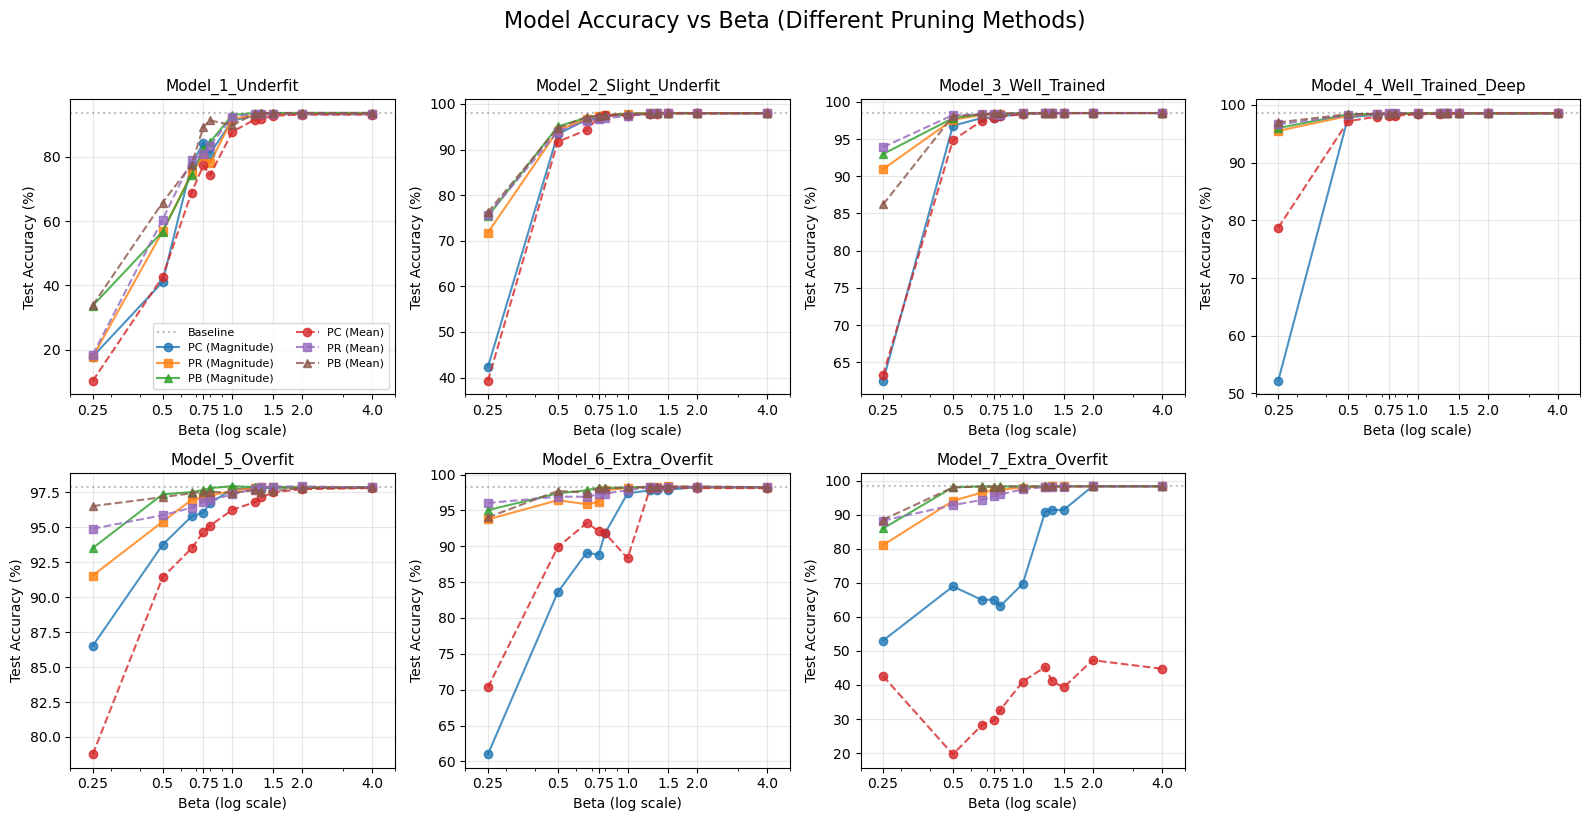

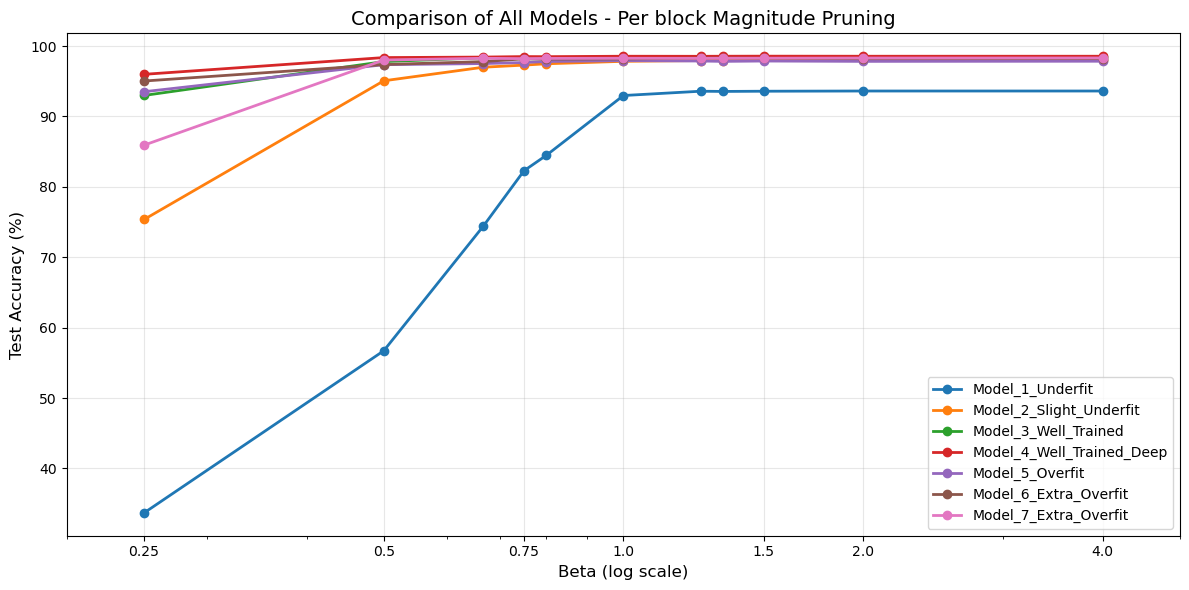


Summary Statistics:

Model_1_Underfit:
  Baseline Accuracy: 93.61%
  Best Pruned: 93.67% (Model_1_Underfit_pb_1.3333333333333333_mean)
  Worst Pruned: 10.32% (Model_1_Underfit_pc_0.25_mean)
  Accuracy Drop Range: 83.29% to -0.06%

Model_2_Slight_Underfit:
  Baseline Accuracy: 97.99%
  Best Pruned: 98.08% (Model_2_Slight_Underfit_pr_1.5_mean)
  Worst Pruned: 39.29% (Model_2_Slight_Underfit_pc_0.25_mean)
  Accuracy Drop Range: 58.70% to -0.09%

Model_3_Well_Trained:
  Baseline Accuracy: 98.49%
  Best Pruned: 98.53% (Model_3_Well_Trained_pc_1.25_mean)
  Worst Pruned: 62.53% (Model_3_Well_Trained_pc_0.25_magnitude)
  Accuracy Drop Range: 35.96% to -0.04%

Model_4_Well_Trained_Deep:
  Baseline Accuracy: 98.56%
  Best Pruned: 98.65% (Model_4_Well_Trained_Deep_pr_1.25_mean)
  Worst Pruned: 52.19% (Model_4_Well_Trained_Deep_pc_0.25_magnitude)
  Accuracy Drop Range: 46.37% to -0.09%

Model_5_Overfit:
  Baseline Accuracy: 97.85%
  Best Pruned: 97.94% (Model_5_Overfit_pb_1.0_magnitude)
  Worst P

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'result' dictionary is already populated with your experimental data
# result = {'model_name': [...], 'test_accuracy': [...], 'model_sparsity': [...]}

# Convert result dictionary to DataFrame for easier manipulation
df = pd.DataFrame(result)

# Define beta values used in experiments
betas = [0.25, 0.5, 2/3, 0.75, 0.8, 1.0, 5/4, 4/3, 3/2, 2.0, 4.0]

# Extract unique base model names (without pruning suffixes)
base_models = []
for name in df['model_name']:
    if '_pc_' not in name and '_pr_' not in name and '_pb_' not in name:
        base_models.append(name)

# Get unique base models
unique_base_models = []
for model in base_models:
    if model not in unique_base_models:
        unique_base_models.append(model)

# Create figure with subplots
n_models = len(unique_base_models)
n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
fig.suptitle('Model Accuracy vs Beta (Different Pruning Methods)', fontsize=16, y=1.02)

# Flatten axes for easier iteration
if n_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Colors and styles for different pruning methods
colors = {
    'magnitude': {'pc': '#1f77b4', 'pr': '#ff7f0e', 'pb': '#2ca02c'},
    'mean': {'pc': '#d62728', 'pr': '#9467bd', 'pb': '#8c564b'}
}

markers = {'pc': 'o', 'pr': 's', 'pb': '^'}
linestyles = {'magnitude': '-', 'mean': '--'}

# Plot for each model
for idx, base_model in enumerate(unique_base_models):
    ax = axes[idx]
    
    # Get base accuracy (model without pruning)
    base_idx = df[df['model_name'] == base_model].index[0]
    base_accuracy = df.loc[base_idx, 'test_accuracy']
    
    # Plot baseline
    ax.axhline(y=base_accuracy, color='gray', linestyle=':', alpha=0.5, label='Baseline')
    
    # Extract data for each pruning method
    for method in ['magnitude', 'mean']:
        for pruning_type in ['pc', 'pr', 'pb']:
            accuracies = []
            
            for beta in betas:
                # Find the corresponding row in the dataframe
                model_name_pattern = f"{base_model}_{pruning_type}_{beta}_{method}"
                matching_rows = df[df['model_name'] == model_name_pattern]
                
                if not matching_rows.empty:
                    accuracies.append(matching_rows['test_accuracy'].values[0])
                else:
                    accuracies.append(np.nan)
            
            # Plot with log scale for beta
            label = f"{pruning_type.upper()} ({method.capitalize()})"
            ax.semilogx(betas, accuracies, 
                       color=colors[method][pruning_type],
                       marker=markers[pruning_type],
                       linestyle=linestyles[method],
                       label=label,
                       markersize=6,
                       alpha=0.8)
    
    # Formatting
    ax.set_xlabel('Beta (log scale)', fontsize=10)
    ax.set_ylabel('Test Accuracy (%)', fontsize=10)
    ax.set_title(f'{base_model}', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.2, 5])
    
    # Set x-axis ticks
    ax.set_xticks([0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0])
    ax.set_xticklabels(['0.25', '0.5', '0.75', '1.0', '1.5', '2.0', '4.0'])
    
    # Add legend only to the first subplot
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8, ncol=2)

# Hide empty subplots
for idx in range(n_models, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Additional plot: All models comparison for a specific pruning method
fig2, ax2 = plt.subplots(figsize=(12, 6))

# Choose one pruning method to compare across models (e.g., pc_magnitude)
pruning_method = 'pb'
pruning_type = 'magnitude'

for base_model in unique_base_models:
    accuracies = []
    
    for beta in betas:
        model_name_pattern = f"{base_model}_{pruning_method}_{beta}_{pruning_type}"
        matching_rows = df[df['model_name'] == model_name_pattern]
        
        if not matching_rows.empty:
            accuracies.append(matching_rows['test_accuracy'].values[0])
        else:
            accuracies.append(np.nan)
    
    ax2.semilogx(betas, accuracies, marker='o', label=base_model, linewidth=2, markersize=6)

ax2.set_xlabel('Beta (log scale)', fontsize=12)
ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
ax2.set_title(f'Comparison of All Models - Per block Magnitude Pruning', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower right', fontsize=10)
ax2.set_xlim([0.2, 5])
ax2.set_xticks([0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0])
ax2.set_xticklabels(['0.25', '0.5', '0.75', '1.0', '1.5', '2.0', '4.0'])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("="*60)
for base_model in unique_base_models:
    print(f"\n{base_model}:")
    base_idx = df[df['model_name'] == base_model].index[0]
    base_acc = df.loc[base_idx, 'test_accuracy']
    print(f"  Baseline Accuracy: {base_acc:.2f}%")
    
    # Find best and worst performance
    model_data = df[df['model_name'].str.startswith(base_model + '_')]
    if not model_data.empty:
        best_acc = model_data['test_accuracy'].max()
        worst_acc = model_data['test_accuracy'].min()
        best_model = model_data.loc[model_data['test_accuracy'].idxmax(), 'model_name']
        worst_model = model_data.loc[model_data['test_accuracy'].idxmin(), 'model_name']
        
        print(f"  Best Pruned: {best_acc:.2f}% ({best_model})")
        print(f"  Worst Pruned: {worst_acc:.2f}% ({worst_model})")
        print(f"  Accuracy Drop Range: {base_acc - worst_acc:.2f}% to {base_acc - best_acc:.2f}%")

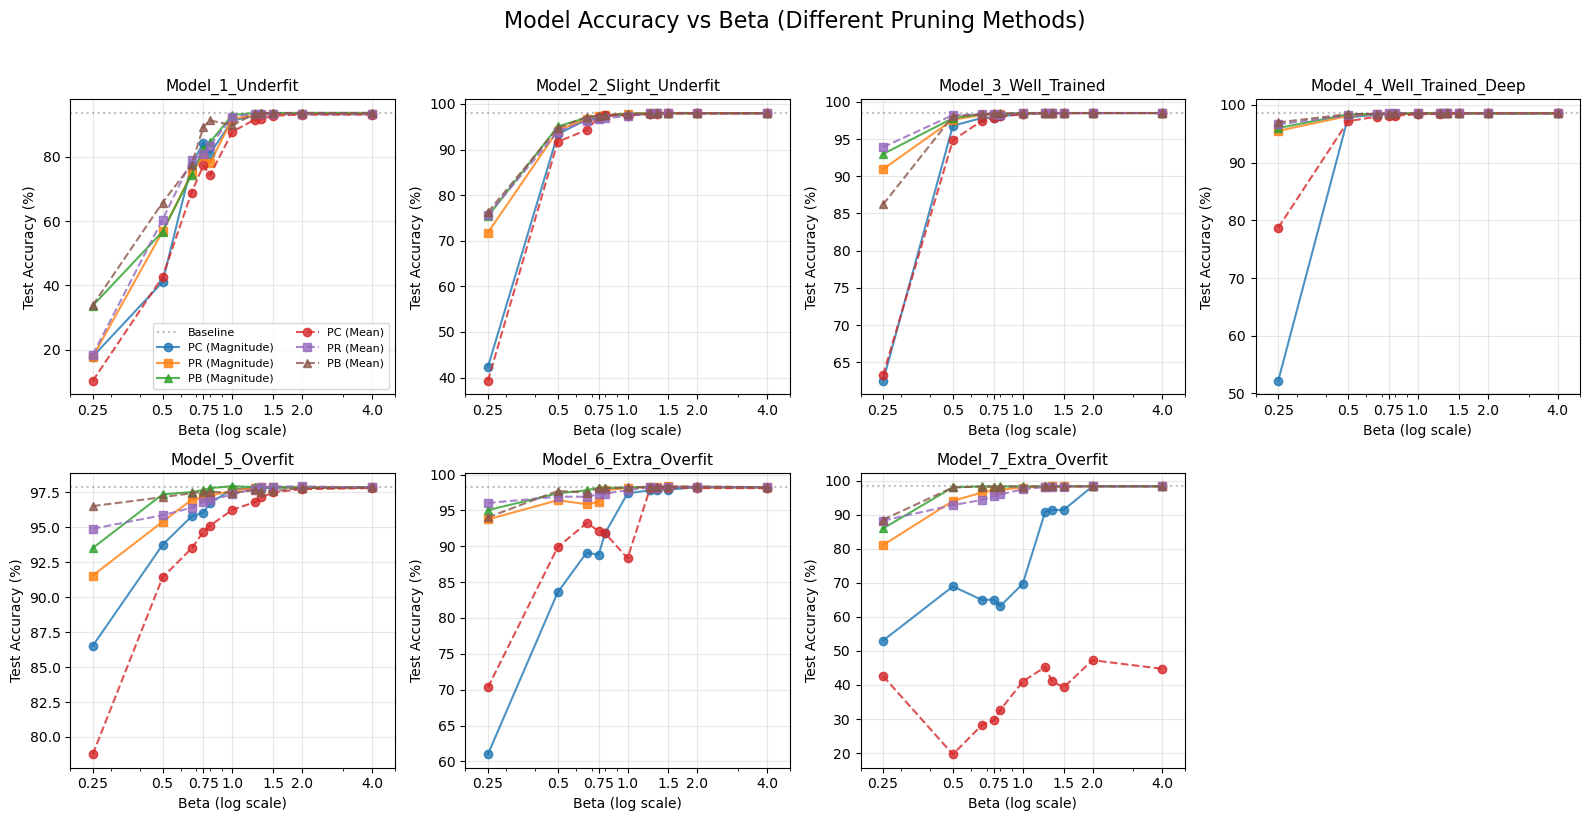

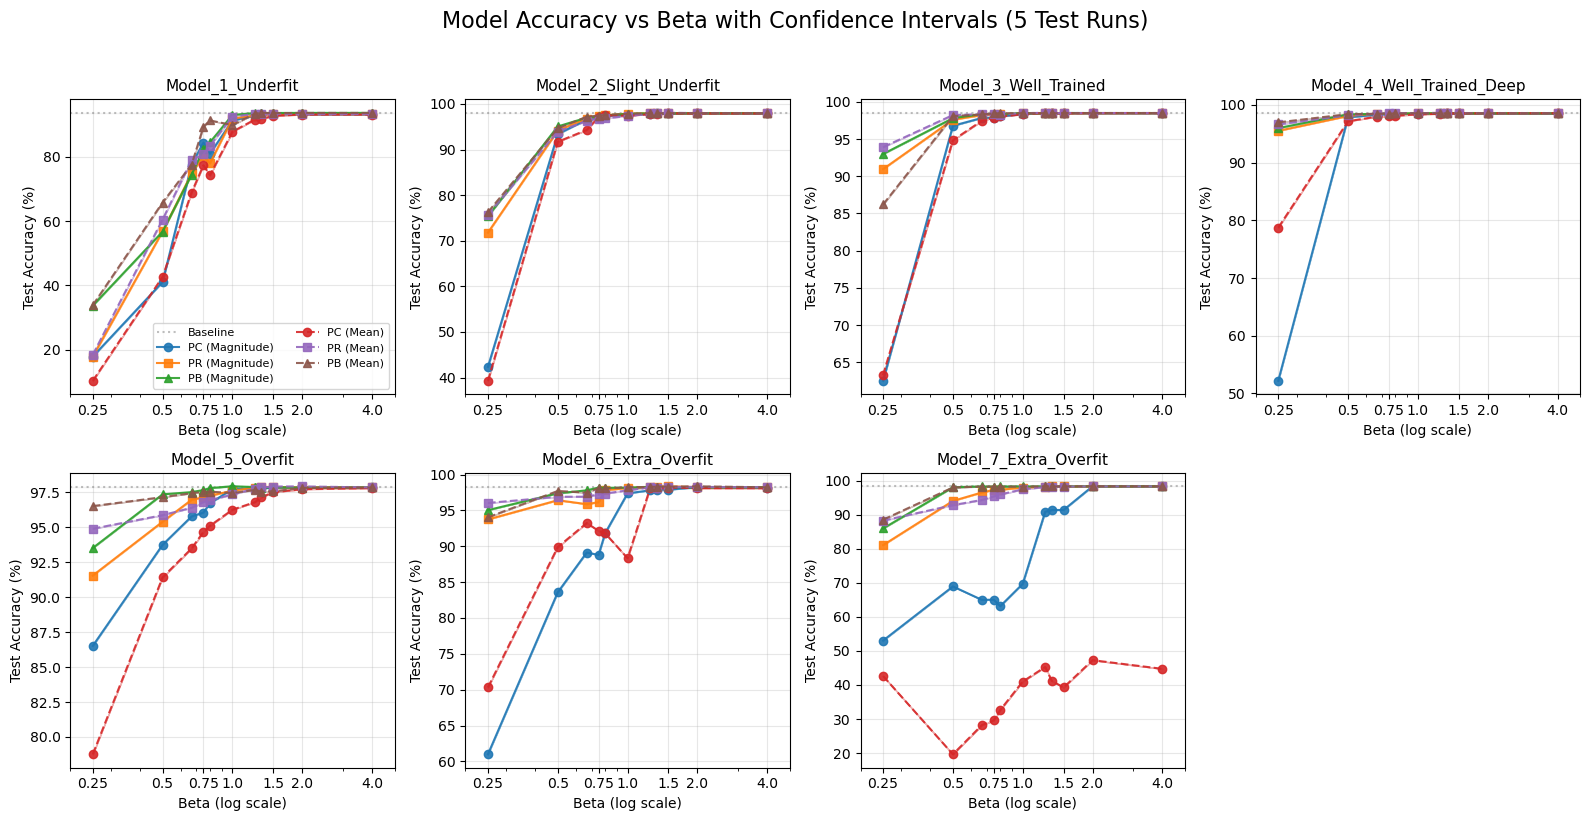


Summary Statistics with Variance Information:

Model_1_Underfit:
  Baseline: 93.61% (std: 0.00%, range: [93.61, 93.61])
  Best Pruned: 94.81% ± 0.00% (Model_1_Underfit_pc_2.0_mean)
  Worst Pruned: 10.28% ± 0.00% (Model_1_Underfit_pr_0.25_mean)

Model_2_Slight_Underfit:
  Baseline: 97.99% (std: 0.00%, range: [97.99, 97.99])
  Best Pruned: 98.08% ± 0.00% (Model_2_Slight_Underfit_pr_1.5_mean)
  Worst Pruned: 29.54% ± 0.00% (Model_2_Slight_Underfit_pb_0.25_magnitude)

Model_3_Well_Trained:
  Baseline: 98.49% (std: 0.00%, range: [98.49, 98.49])
  Best Pruned: 98.53% ± 0.00% (Model_3_Well_Trained_pc_1.25_mean)
  Worst Pruned: 35.93% ± 0.00% (Model_3_Well_Trained_pb_0.25_mean)

Model_4_Well_Trained_Deep:
  Baseline: 98.56% (std: 0.00%, range: [98.56, 98.56])
  Best Pruned: 98.65% ± 0.00% (Model_4_Well_Trained_Deep_pr_1.25_mean)
  Worst Pruned: 33.45% ± 0.00% (Model_4_Well_Trained_Deep_pb_0.25_mean)

Model_5_Overfit:
  Baseline: 97.85% (std: 0.00%, range: [97.85, 97.85])
  Best Pruned: 98.32%

C:\Users\PC\AppData\Local\Temp\ipykernel_59008\71534819.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['mean_accuracy'] = mean_accs
C:\Users\PC\AppData\Local\Temp\ipykernel_59008\71534819.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['mean_accuracy'] = mean_accs
C:\Users\PC\AppData\Local\Temp\ipykernel_59008\71534819.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'result' dictionary is already populated with your experimental data
# result = {'model_name': [...], 'test_accuracy': [...], 'model_sparsity': [...], 'shadow_accuracy': [...]}

# Convert result dictionary to DataFrame for easier manipulation
df = pd.DataFrame(result)

# Define beta values used in experiments
betas = [0.25, 0.5, 2/3, 0.75, 0.8, 1.0, 5/4, 4/3, 3/2, 2.0, 4.0]

# Extract unique base model names (without pruning suffixes)
base_models = []
for name in df['model_name']:
    if '_pc_' not in name and '_pr_' not in name and '_pb_' not in name:
        base_models.append(name)

# Get unique base models
unique_base_models = []
for model in base_models:
    if model not in unique_base_models:
        unique_base_models.append(model)

# ========== FIGURE 1: Standard Accuracy vs Beta ==========
n_models = len(unique_base_models)
n_cols = 4
n_rows = (n_models + n_cols - 1) // n_cols
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
fig1.suptitle('Model Accuracy vs Beta (Different Pruning Methods)', fontsize=16, y=1.02)

# Flatten axes for easier iteration
if n_models == 1:
    axes1 = [axes1]
else:
    axes1 = axes1.flatten()

# Colors and styles for different pruning methods
colors = {
    'magnitude': {'pc': '#1f77b4', 'pr': '#ff7f0e', 'pb': '#2ca02c'},
    'mean': {'pc': '#d62728', 'pr': '#9467bd', 'pb': '#8c564b'}
}

markers = {'pc': 'o', 'pr': 's', 'pb': '^'}
linestyles = {'magnitude': '-', 'mean': '--'}

# Plot for each model
for idx, base_model in enumerate(unique_base_models):
    ax = axes1[idx]
    
    # Get base accuracy (model without pruning)
    base_idx = df[df['model_name'] == base_model].index[0]
    base_accuracy = df.loc[base_idx, 'test_accuracy']
    
    # Plot baseline
    ax.axhline(y=base_accuracy, color='gray', linestyle=':', alpha=0.5, label='Baseline')
    
    # Extract data for each pruning method
    for method in ['magnitude', 'mean']:
        for pruning_type in ['pc', 'pr', 'pb']:
            accuracies = []
            
            for beta in betas:
                # Find the corresponding row in the dataframe
                model_name_pattern = f"{base_model}_{pruning_type}_{beta}_{method}"
                matching_rows = df[df['model_name'] == model_name_pattern]
                
                if not matching_rows.empty:
                    accuracies.append(matching_rows['test_accuracy'].values[0])
                else:
                    accuracies.append(np.nan)
            
            # Plot with log scale for beta
            label = f"{pruning_type.upper()} ({method.capitalize()})"
            ax.semilogx(betas, accuracies, 
                       color=colors[method][pruning_type],
                       marker=markers[pruning_type],
                       linestyle=linestyles[method],
                       label=label,
                       markersize=6,
                       alpha=0.8)
    
    # Formatting
    ax.set_xlabel('Beta (log scale)', fontsize=10)
    ax.set_ylabel('Test Accuracy (%)', fontsize=10)
    ax.set_title(f'{base_model}', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.2, 5])
    
    # Set x-axis ticks
    ax.set_xticks([0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0])
    ax.set_xticklabels(['0.25', '0.5', '0.75', '1.0', '1.5', '2.0', '4.0'])
    
    # Add legend only to the first subplot
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8, ncol=2)

# Hide empty subplots
for idx in range(n_models, len(axes1)):
    axes1[idx].set_visible(False)

plt.tight_layout()
plt.show()

# ========== FIGURE 2: Accuracy with Confidence Intervals (Shadow) ==========
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
fig2.suptitle('Model Accuracy vs Beta with Confidence Intervals (5 Test Runs)', fontsize=16, y=1.02)

# Flatten axes for easier iteration
if n_models == 1:
    axes2 = [axes2]
else:
    axes2 = axes2.flatten()

# Plot for each model with shadow
for idx, base_model in enumerate(unique_base_models):
    ax = axes2[idx]
    
    # Get base accuracy and shadow accuracy
    base_idx = df[df['model_name'] == base_model].index[0]
    base_accuracy = df.loc[base_idx, 'test_accuracy']
    base_shadow = df.loc[base_idx, 'shadow_accuracy']
    
    # Plot baseline with shadow if available
    if isinstance(base_shadow, list) and len(base_shadow) > 1:
        shadow_mean = np.mean(base_shadow)
        shadow_std = np.std(base_shadow)
        ax.axhline(y=shadow_mean, color='gray', linestyle=':', alpha=0.5, label='Baseline')
        ax.fill_between([0.2, 5], shadow_mean - shadow_std, shadow_mean + shadow_std, 
                       color='gray', alpha=0.1)
    else:
        ax.axhline(y=base_accuracy, color='gray', linestyle=':', alpha=0.5, label='Baseline')
    
    # Extract data for each pruning method
    for method in ['magnitude', 'mean']:
        for pruning_type in ['pc', 'pr', 'pb']:
            means = []
            stds = []
            mins = []
            maxs = []
            
            for beta in betas:
                # Find the corresponding row in the dataframe
                model_name_pattern = f"{base_model}_{pruning_type}_{beta}_{method}"
                matching_rows = df[df['model_name'] == model_name_pattern]
                
                if not matching_rows.empty:
                    shadow_acc = matching_rows['shadow_accuracy'].values[0]
                    
                    # Check if shadow_accuracy is a list with multiple values
                    if isinstance(shadow_acc, list) and len(shadow_acc) > 1:
                        means.append(np.mean(shadow_acc))
                        stds.append(np.std(shadow_acc))
                        mins.append(np.min(shadow_acc))
                        maxs.append(np.max(shadow_acc))
                    else:
                        # Use test_accuracy if shadow_accuracy is not a list
                        acc_value = matching_rows['test_accuracy'].values[0]
                        means.append(acc_value)
                        stds.append(0)
                        mins.append(acc_value)
                        maxs.append(acc_value)
                else:
                    means.append(np.nan)
                    stds.append(np.nan)
                    mins.append(np.nan)
                    maxs.append(np.nan)
            
            # Convert to numpy arrays
            means = np.array(means)
            stds = np.array(stds)
            mins = np.array(mins)
            maxs = np.array(maxs)
            
            # Plot mean line
            label = f"{pruning_type.upper()} ({method.capitalize()})"
            line = ax.semilogx(betas, means, 
                              color=colors[method][pruning_type],
                              marker=markers[pruning_type],
                              linestyle=linestyles[method],
                              label=label,
                              markersize=6,
                              alpha=0.9)[0]
            
            # Add shadow (confidence interval)
            valid_indices = ~np.isnan(means)
            if np.any(valid_indices):
                valid_betas = np.array(betas)[valid_indices]
                valid_mins = mins[valid_indices]
                valid_maxs = maxs[valid_indices]
                
                # Fill between min and max
                ax.fill_between(valid_betas, valid_mins, valid_maxs,
                               color=line.get_color(), alpha=0.15)
                
                # Optionally, also show ±1 std with darker shade
                valid_means = means[valid_indices]
                valid_stds = stds[valid_indices]
                ax.fill_between(valid_betas, 
                               valid_means - valid_stds, 
                               valid_means + valid_stds,
                               color=line.get_color(), alpha=0.25)
    
    # Formatting
    ax.set_xlabel('Beta (log scale)', fontsize=10)
    ax.set_ylabel('Test Accuracy (%)', fontsize=10)
    ax.set_title(f'{base_model}', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.2, 5])
    
    # Set x-axis ticks
    ax.set_xticks([0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 4.0])
    ax.set_xticklabels(['0.25', '0.5', '0.75', '1.0', '1.5', '2.0', '4.0'])
    
    # Add legend only to the first subplot
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8, ncol=2)

# Hide empty subplots
for idx in range(n_models, len(axes2)):
    axes2[idx].set_visible(False)

plt.tight_layout()
plt.show()

# ========== Print Summary Statistics with Variance Info ==========
print("\nSummary Statistics with Variance Information:")
print("="*70)
for base_model in unique_base_models:
    print(f"\n{base_model}:")
    base_idx = df[df['model_name'] == base_model].index[0]
    base_acc = df.loc[base_idx, 'test_accuracy']
    base_shadow = df.loc[base_idx, 'shadow_accuracy']
    
    if isinstance(base_shadow, list) and len(base_shadow) > 1:
        print(f"  Baseline: {base_acc:.2f}% (std: {np.std(base_shadow):.2f}%, range: [{np.min(base_shadow):.2f}, {np.max(base_shadow):.2f}])")
    else:
        print(f"  Baseline: {base_acc:.2f}%")
    
    # Find best and worst performance with variance
    model_data = df[df['model_name'].str.startswith(base_model + '_')]
    if not model_data.empty:
        # Calculate mean accuracies for comparison
        mean_accs = []
        for idx, row in model_data.iterrows():
            if isinstance(row['shadow_accuracy'], list) and len(row['shadow_accuracy']) > 1:
                mean_accs.append(np.mean(row['shadow_accuracy']))
            else:
                mean_accs.append(row['test_accuracy'])
        
        model_data['mean_accuracy'] = mean_accs
        
        best_idx = model_data['mean_accuracy'].idxmax()
        worst_idx = model_data['mean_accuracy'].idxmin()
        
        best_model = model_data.loc[best_idx, 'model_name']
        worst_model = model_data.loc[worst_idx, 'model_name']
        best_shadow = model_data.loc[best_idx, 'shadow_accuracy']
        worst_shadow = model_data.loc[worst_idx, 'shadow_accuracy']
        
        if isinstance(best_shadow, list) and len(best_shadow) > 1:
            print(f"  Best Pruned: {np.mean(best_shadow):.2f}% ± {np.std(best_shadow):.2f}% ({best_model})")
        else:
            print(f"  Best Pruned: {model_data.loc[best_idx, 'test_accuracy']:.2f}% ({best_model})")
            
        if isinstance(worst_shadow, list) and len(worst_shadow) > 1:
            print(f"  Worst Pruned: {np.mean(worst_shadow):.2f}% ± {np.std(worst_shadow):.2f}% ({worst_model})")
        else:
            print(f"  Worst Pruned: {model_data.loc[worst_idx, 'test_accuracy']:.2f}% ({worst_model})")

In [14]:
result

{'model_name': ['Model_1_Underfit',
  'Model_1_Underfit_pc_0.25_magnitude',
  'Model_1_Underfit_pr_0.25_magnitude',
  'Model_1_Underfit_pb_0.25_magnitude',
  'Model_1_Underfit_pc_0.25_mean',
  'Model_1_Underfit_pr_0.25_mean',
  'Model_1_Underfit_pb_0.25_mean',
  'Model_1_Underfit_pc_0.5_magnitude',
  'Model_1_Underfit_pr_0.5_magnitude',
  'Model_1_Underfit_pb_0.5_magnitude',
  'Model_1_Underfit_pc_0.5_mean',
  'Model_1_Underfit_pr_0.5_mean',
  'Model_1_Underfit_pb_0.5_mean',
  'Model_1_Underfit_pc_0.6666666666666666_magnitude',
  'Model_1_Underfit_pr_0.6666666666666666_magnitude',
  'Model_1_Underfit_pb_0.6666666666666666_magnitude',
  'Model_1_Underfit_pc_0.6666666666666666_mean',
  'Model_1_Underfit_pr_0.6666666666666666_mean',
  'Model_1_Underfit_pb_0.6666666666666666_mean',
  'Model_1_Underfit_pc_0.75_magnitude',
  'Model_1_Underfit_pr_0.75_magnitude',
  'Model_1_Underfit_pb_0.75_magnitude',
  'Model_1_Underfit_pc_0.75_mean',
  'Model_1_Underfit_pr_0.75_mean',
  'Model_1_Underfit_p